In [0]:

#!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
#!pip3 install torchvision
!pip3 install GPy

import pandas as pd
import zipfile
import urllib.request
import os
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'


In [0]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla T4'

In [0]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for i in var:
        
        if isinstance(i, np.ndarray):
            i = torch.from_numpy(i).type(torch.FloatTensor)

        if not i.is_cuda and cuda:
            i = i.cuda()

        if not isinstance(i, Variable):
            i = Variable(i, volatile=volatile)

        out.append(i)
    return out

In [0]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()
        

In [0]:
class MC_Dropout_Wrapper:
    def __init__(self, network, learn_rate, batch_size, weight_decay):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
        
        loss.backward()
        self.optimizer.step()

        return loss
    
    def get_loss_and_rmse(self, x, y, num_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(num_samples):
            output = self.network(x)
            means.append(output[:, :1])
            stds.append(output[:, 1:].exp())
        
        means, stds = torch.cat(means, dim=1), torch.cat(stds, dim=1)
        mean = means.mean(dim=-1)[:, None]
        std = ((means.var(dim=-1) + stds.mean(dim=-1)**2)**0.5)[:, None]
        loss = self.loss_func(mean, y, std, 1)
        
        rmse = ((mean - y)**2).mean()**0.5

        return loss.detach().cpu(), rmse.detach().cpu(), output   #added output

# Dropout Model

In [0]:
class Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(Dropout_Model, self).__init__()
        

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob
        
        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2*output_dim)
        
        self.activation = nn.ReLU(inplace = True)

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        x = self.layer2(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        x = self.layer3(x)
        
        return x

#Training

In [0]:
def train_mc_dropout(data, drop_prob, n_splits, num_epochs, num_units, learn_rate, weight_decay, log_every, num_samples):
    
    kf = KFold(n_splits=n_splits)
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []
    xtrain_rmse, xtest_rmse = [], []
    rmse = []

    split = np.random.rand(len(data)) < 0.9

    train = data[split]

    test = data[~split]#

    in_dim = data.shape[1] - 1

    x_train, y_train = train[:, :in_dim], train[:, in_dim:]

    x_test, y_test = test[:, :in_dim], test[:, in_dim:]

    print(x_train.shape)
    print(y_train.shape)


    x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
    y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

    x_train = (x_train - x_means)/x_stds
    y_train = (y_train - y_means)/y_stds

    x_test = (x_test - x_means)/x_stds
    y_test = (y_test - y_means)/y_stds
    
    num_epochs, batch_size = num_epochs, len(x_train)
    
    net = MC_Dropout_Wrapper(network=Dropout_Model(input_dim=in_dim, output_dim=1, num_units=num_units, drop_prob=drop_prob),
                             learn_rate=learn_rate, batch_size=batch_size, weight_decay=weight_decay)

    losses = []
    fit_loss_train = np.zeros(num_epochs)

    for i in range(num_epochs):
        loss = net.fit(x_train, y_train)

        if i % log_every == 0 or i == num_epochs - 1:
            test_loss, rmse, test_pred = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
            test_loss, rmse = test_loss.cpu().data.numpy(), rmse.cpu().data.numpy()

            print('Epoch: %4d, Train loss: %6.3f Test loss: %6.3f RMSE: %.3f Num. networks: %2d' %
                  (i, loss.cpu().data.numpy()/len(x_train), test_loss/len(x_test), rmse*y_stds[0], len(x_train)))


        train_loss, train_rmse, train_pred = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
        test_loss, test_rmse, test_pred = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)

        xtrain_rmse.append(np.asscalar(train_rmse*y_stds[0]))
        xtest_rmse.append(np.asscalar(test_rmse*y_stds[0]))
    
    
    train_logliks.append((train_loss.cpu().data.numpy()/len(x_train) + np.log(y_stds)[0]))
    test_logliks.append((test_loss.cpu().data.numpy()/len(x_test) + np.log(y_stds)[0]))

    train_rmses.append(y_stds[0]*train_rmse.cpu().data.numpy())
    test_rmses.append(y_stds[0]*test_rmse.cpu().data.numpy())



    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var()**0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var()**0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var()**0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var()**0.5))
    
   
    return x_train, y_train, x_test, y_test, test_pred, net

# Evaluation - PICP and MPIW

In [0]:

def evaluation(y_test, test_pred):
  
  print (test_pred.shape)
  test_pred = test_pred.data.cpu().numpy()
  mean_np = test_pred.mean(1)
  std_np = test_pred.std(1)
  print (mean_np.shape)
  print (std_np.shape)
 
   
  #calculate the upper and lower bounds of y using 95% prediction interval
  
  y_u_pred = mean_np + (std_np * 1.96)  #upper 95% limit
  y_l_pred = mean_np - (std_np * 1.96)  #lower 95% limit
  print (y_u_pred.shape)
  print (y_l_pred.shape)
    
  y_val = y_test
  print (y_val.shape)
  K_u = y_u_pred > y_val
  K_l = y_l_pred < y_val
  y_all_cap = K_u * K_l

  #calculate PICP and MPIW
  PICP = np.mean(K_u * K_l)
  MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
  return PICP, MPIW

#Housing Dataset

In [0]:
np.random.seed(0)
url_housing = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/boston_housing.txt'
data_housing = pd.read_csv(url_housing, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]

In [0]:
x_train_housing, y_train_housing, x_test_housing, y_test_housing, test_pred_housing, model_housing = train_mc_dropout(data=data_housing, drop_prob=0.2, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data_housing)**0.5, num_samples=20, log_every=50)

(448, 13)
(448, 1)
Epoch:    0, Train loss:  1.439 Test loss:  1.306 RMSE: 8.092 Num. networks: 448
Epoch:   50, Train loss:  0.637 Test loss:  0.495 RMSE: 3.814 Num. networks: 448
Epoch:   99, Train loss:  0.504 Test loss:  0.441 RMSE: 3.761 Num. networks: 448
Train log. lik. = -2.667 +/-  0.000
Test  log. lik. = -2.682 +/-  0.000
Train RMSE      =  3.976 +/-  0.000
Test  RMSE      =  3.727 +/-  0.000


In [0]:
PICP_housing, MPIW_housing = evaluation (y_test_housing, test_pred_housing)
print ('PICP: ', PICP_housing)
print ('MPIW: ', MPIW_housing)

torch.Size([59, 2])
(59,)
(59,)
(59,)
(59,)
(59, 1)
PICP:  0.5489801781097385
MPIW:  1.87


# Concrete compressive dataset

In [0]:
np.random.seed(0)
url_concrete = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/concrete.txt'
data_concrete = pd.read_csv(url_concrete, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]


(918, 8)
(918, 1)
Epoch:    0, Train loss:  1.440 Test loss:  1.300 RMSE: 14.408 Num. networks: 918
Epoch:   50, Train loss:  0.751 Test loss:  0.757 RMSE: 9.307 Num. networks: 918
Epoch:   99, Train loss:  0.929 Test loss:  0.828 RMSE: 8.819 Num. networks: 918
Train log. lik. = -3.659 +/-  0.000
Test  log. lik. = -3.659 +/-  0.000
Train RMSE      =  8.922 +/-  0.000
Test  RMSE      =  8.892 +/-  0.000


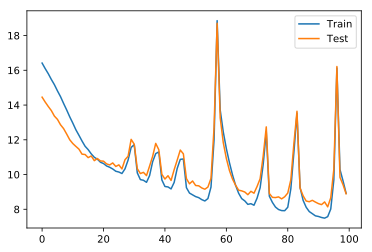

In [0]:
x_train_concrete, y_train_concrete, x_test_concrete, y_test_concrete, test_pred_concrete, model_concrete = train_mc_dropout(data=data_concrete, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data_concrete)**0.5, num_samples=20, log_every=50)


In [0]:
PICP_concrete, MPIW_concrete = evaluation (y_test_concrete, test_pred_concrete)
print ('PICP: ', PICP_concrete)
print ('MPIW: ', MPIW_concrete)

torch.Size([111, 2])
(111,)
(111,)
(111,)
(111,)
(111, 1)
PICP:  0.36109082055028
MPIW:  0.931


# Energy efficiency dataset

In [0]:
np.random.seed(0)
url_energy = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/energy_heating_load.txt'
data_energy = pd.read_csv(url_energy, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]


(681, 8)
(681, 1)
Epoch:    0, Train loss:  1.458 Test loss:  1.383 RMSE: 9.838 Num. networks: 681
Epoch:   50, Train loss:  1.022 Test loss:  0.981 RMSE: 8.496 Num. networks: 681
Epoch:   99, Train loss:  1.152 Test loss:  1.140 RMSE: 7.904 Num. networks: 681
Train log. lik. = -3.405 +/-  0.000
Test  log. lik. = -3.443 +/-  0.000
Train RMSE      =  7.565 +/-  0.000
Test  RMSE      =  7.874 +/-  0.000


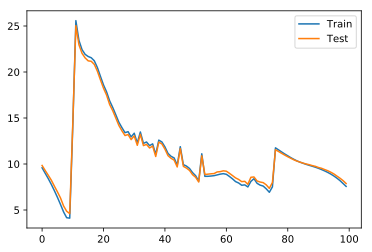

In [0]:
x_train_energy, y_train_energy, x_test_energy, y_test_energy, test_pred_energy, model_energy = train_mc_dropout(data=data_energy, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data_energy)**0.5, num_samples=20, log_every=50)

In [0]:
PICP_energy, MPIW_energy = evaluation (y_test_energy, test_pred_energy)
print ('PICP: ', PICP_energy)
print ('MPIW: ', MPIW_energy)

torch.Size([86, 2])
(86,)
(86,)
(86,)
(86,)
(86, 1)
PICP:  0.21538669551108708
MPIW:  0.88


# Power dataset

In [0]:
np.random.seed(0)
url_power = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/power.txt'
data_power = pd.read_csv(url_power, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]

#np.random.shuffle(data)

(8623, 4)
(8623, 1)
Epoch:    0, Train loss:  1.479 Test loss:  2.067 RMSE: 6.744 Num. networks: 8623
Epoch:   50, Train loss:    nan Test loss:    nan RMSE: nan Num. networks: 8623
Epoch:   99, Train loss:    nan Test loss:    nan RMSE: nan Num. networks: 8623
Train log. lik. =    nan +/-    nan
Test  log. lik. =    nan +/-    nan
Train RMSE      =    nan +/-    nan
Test  RMSE      =    nan +/-    nan


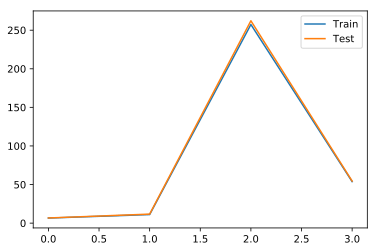

In [0]:
x_train_power, y_train_power, x_test_power, y_test_power, test_pred_power, model_power = train_mc_dropout(data=data_power, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data_power)**0.5, num_samples=20, log_every=50)

In [0]:
PICP_power, MPIW_power = evaluation (y_test_power, test_pred_power)
print ('PICP: ', PICP_power)
print ('MPIW: ', MPIW_power)

torch.Size([944, 2])
(944,)
(944,)
(944,)
(944,)
(944, 1)
PICP:  0.0
MPIW:  nan


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:invalid value encountered in greater
 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning:invalid value encountered in less


# Red wine dataset

In [0]:
np.random.seed(0)
url_wine = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/wine.txt'
data_wine = pd.read_csv(url_wine, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]

(1411, 11)
(1411, 1)
Epoch:    0, Train loss:  1.426 Test loss:  1.420 RMSE: 0.811 Num. networks: 1411
Epoch:   50, Train loss:  1.147 Test loss:  1.131 RMSE: 0.641 Num. networks: 1411
Epoch:   99, Train loss:  1.100 Test loss:  1.113 RMSE: 0.633 Num. networks: 1411
Train log. lik. = -0.868 +/-  0.000
Test  log. lik. = -0.891 +/-  0.000
Train RMSE      =  0.612 +/-  0.000
Test  RMSE      =  0.633 +/-  0.000


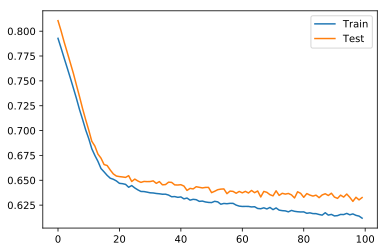

In [0]:
x_train_wine, y_train_wine, x_test_wine, y_test_wine, test_pred_wine, model_wine = train_mc_dropout(data=data_wine, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data_wine)**0.5, num_samples=20, log_every=50)

In [0]:
PICP_wine, MPIW_wine = evaluation (y_test_wine, test_pred_wine)
print ('PICP: ', PICP_wine)
print ('MPIW: ', MPIW_wine)

torch.Size([187, 2])
(187,)
(187,)
(187,)
(187,)
(187, 1)
PICP:  0.22070977151191054
MPIW:  0.944


# Yacht dataset

In [0]:
np.random.seed(0)
url_yatch = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/yacht.txt'
data_yatch = pd.read_csv(url_yatch, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]

(274, 6)
(274, 1)
Epoch:    0, Train loss:  1.445 Test loss:  1.183 RMSE: 11.490 Num. networks: 274
Epoch:   50, Train loss:  1.406 Test loss:  1.285 RMSE: 12.074 Num. networks: 274
Epoch:   99, Train loss:  0.165 Test loss: -0.010 RMSE: 5.451 Num. networks: 274
Train log. lik. = -2.806 +/-  0.000
Test  log. lik. = -2.692 +/-  0.000
Train RMSE      =  9.367 +/-  0.000
Test  RMSE      =  5.077 +/-  0.000


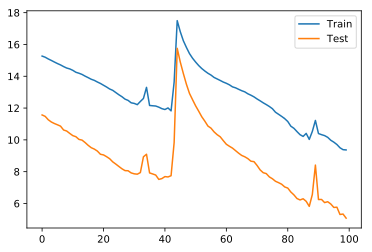

In [0]:
x_train_yatch, y_train_yatch, x_test_yatch, y_test_yatch, test_pred_yatch, model_yatch = train_mc_dropout(data=data_yatch, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data_yatch)**0.5, num_samples=20, log_every=50)

In [0]:
PICP_yatch, MPIW_yatch = evaluation (y_test_yatch, test_pred_yatch)
print ('PICP: ', PICP_yatch)
print ('MPIW: ', MPIW_yatch)

torch.Size([33, 2])
(33,)
(33,)
(33,)
(33,)
(33, 1)
PICP:  0.657483930211203
MPIW:  1.915


# Kin8nm

In [0]:
np.random.seed(0)
url_kin8nm = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/kin8nm.txt'
data_kin8nm = pd.read_csv(url_kin8nm, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]

(7374, 8)
(7374, 1)
Epoch:    0, Train loss:  1.441 Test loss:  1.496 RMSE: 0.250 Num. networks: 7374
Epoch:   50, Train loss:    nan Test loss:    nan RMSE: nan Num. networks: 7374
Epoch:   99, Train loss:    nan Test loss:    nan RMSE: nan Num. networks: 7374
Train log. lik. =    nan +/-    nan
Test  log. lik. =    nan +/-    nan
Train RMSE      =    nan +/-    nan
Test  RMSE      =    nan +/-    nan


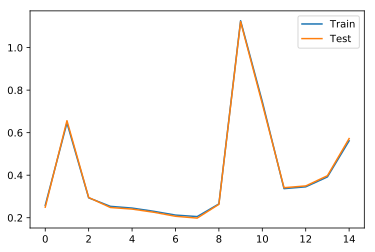

In [0]:
x_train_kin8nm, y_train_kin8nm, x_test_kin8nm, y_test_kin8nm, test_pred_kin8nm, model_kin8nm = train_mc_dropout(data=data_kin8nm, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data_kin8nm)**0.5, num_samples=20, log_every=50)

In [0]:
PICP_kin8nm, MPIW_kin8nm = evaluation (y_test_kin8nm, test_pred_kin8nm)
print ('PICP: ', PICP_kin8nm)
print ('MPIW: ', MPIW_kin8nm)

torch.Size([817, 2])
(817,)
(817,)
(817,)
(817,)
(817, 1)
PICP:  0.0
MPIW:  nan


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:invalid value encountered in greater
 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning:invalid value encountered in less


# Naval compressor

In [0]:
np.random.seed(0)
url_naval = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/naval_compressor_decay.txt'
data_naval = pd.read_csv(url_naval, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]
data_naval.shape
#data_naval = data_naval.drop([-1])
data_naval = np.delete(data_naval, -1, axis=1)

(10742, 15)
(10742, 1)
Epoch:    0, Train loss:    nan Test loss:    nan RMSE: nan Num. networks: 10742


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning:invalid value encountered in true_divide
 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning:invalid value encountered in true_divide


Epoch:   50, Train loss:    nan Test loss:    nan RMSE: nan Num. networks: 10742
Epoch:   99, Train loss:    nan Test loss:    nan RMSE: nan Num. networks: 10742
Train log. lik. =    nan +/-    nan
Test  log. lik. =    nan +/-    nan
Train RMSE      =    nan +/-    nan
Test  RMSE      =    nan +/-    nan


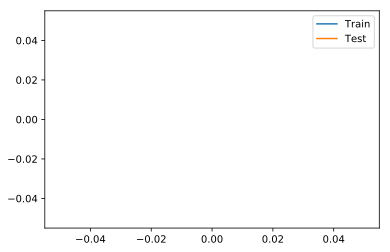

In [0]:
x_train_naval, y_train_naval, x_test_naval, y_test_naval, test_pred_naval, model_naval = train_mc_dropout(data=data_naval, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data_naval)**0.5, num_samples=20, log_every=50)

In [0]:
PICP_naval, MPIW_naval = evaluation (y_test_naval, test_pred_naval)
print ('PICP: ', PICP_naval)
print ('MPIW: ', MPIW_naval)

torch.Size([1191, 2])
(1191,)
(1191,)
(1191,)
(1191,)
(1191, 1)
PICP:  0.0
MPIW:  nan


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:invalid value encountered in greater
 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning:invalid value encountered in less


# Protein

In [0]:
np.random.seed(0)
url_protein = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/protein.txt'
data_protein = pd.read_csv(url_protein, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]

In [0]:
x_train_protein, y_train_protein, x_test_protein, y_test_protein, test_pred_protein, model_protein = train_mc_dropout(data=data_protein, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data_protein)**0.5, num_samples=20, log_every=50)

(41156, 9)
(41156, 1)
Epoch:    0, Train loss:  1.445 Test loss:    inf RMSE: 15.231 Num. networks: 41156


KeyboardInterrupt: ignored

In [0]:
PICP_protein, MPIW_protein = evaluation (y_test_protein, test_pred_protein)
print ('PICP: ', PICP_protein)
print ('MPIW: ', MPIW_protein)

#Year prediction MSD

In [0]:
np.random.seed(0)
url_year = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/year_prediction_msd.txt'
data_year = pd.read_csv(url_year, header=0, delimiter="\s+").values
print (data_year)
#data = data[np.random.permutation(np.arange(len(data)))]

In [0]:
x_train_year, y_train_year, x_test_year, y_test_year, test_pred_year, model_year = train_mc_dropout(data=data_year, drop_prob=0.1, num_epochs=100, n_splits=10, num_units=100, learn_rate=1e-4,
                       weight_decay=1e-1/len(data_year)**0.5, num_samples=20, log_every=50)

In [0]:
PICP_year, MPIW_year = evaluation (y_test_year, test_pred_year)
print ('PICP: ', PICP_year)
print ('MPIW: ', MPIW_year)